# Plot scan

In [11]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from auxPlots import interpolateData, getContours
import seaborn as sns
from nloSbottomXsec import xsecF
pd.option_context('display.max_columns', -1)
import os
pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

### Load Recast Data

In [74]:
files = {
         'ATLAS-SUSY-2018-42' :'../results_dataFrames/pp2BB1j_2018_42_latest.pcl',
         'ATLAS-SUSY-2018-13' :'../results_dataFrames/pp2BB1j_2018_13_latest.pcl',
         'ATLAS-SUSY-2016-08' :'../results_dataFrames/pp2BB1j_2016_08_latest.pcl',
         'CMS-EXO-19-010' : '../results_dataFrames/pp2BB1j_cms_exo_19_010.pcl',
         'CMS-EXO-19-010 (dR cut)' : '../results_dataFrames/pp2BB1j_cms_exo_19_010_dRcut.pcl',
         'CMS-EXO-20-004' :'../results_dataFrames/pp2BB1j_cms_latest.pcl',
         'ATLAS-SUSY-2016-08 (average)' :'../results_dataFrames/pp2BB1j_2016_08_average_latest.pcl',
         'ATLAS-SUSY-2016-08 (nearest)' :'../results_dataFrames/pp2BB1j_2016_08_nearest_latest.pcl',
         'CMS-EXO-20-004 (LLP veto)' :'../results_dataFrames/pp2BB1j_cms_llpveto_latest.pcl',
         }

recastDataDict = {label : pd.read_pickle(f) for label,f in files.items()}

pts_scan = np.genfromtxt('../CDFOdata_2112_01499v3_Fig9_Good.dat',skip_header=6,names=True)
maxCurve = []
for mn1 in np.unique(pts_scan['mxGeV']):
    i = np.argmin(pts_scan[pts_scan['mxGeV'] == mn1]['ctaum'])
    ctaumin = pts_scan[pts_scan['mxGeV'] == mn1]['ctaum'][i]
    msb = pts_scan[pts_scan['mxGeV'] == mn1]['msbGeV'][i]
    maxCurve.append([mn1,ctaumin,msb])
maxCurve = np.array(maxCurve)

### Remove Stable points (delta m < 5 GeV)

In [4]:
for label,recastData in recastDataDict.items():
    recastDataDict[label] = recastData[(recastData['mLLP']-recastData['mLSP']) >= 5.0]

### Compute k-factors

In [5]:
for label,df in recastDataDict.items():
    kfactors = []
    for irow,row in df.iterrows():
        msb = row['mLLP']
        xsec = row['Total xsec (pb)']
        k = xsecF(msb)/xsec
        kfactors.append(k)
    df['kfactor'] = kfactors

### Get all model points

In [6]:
msb = 'mLLP'
mn1= 'mLSP'
tau = 'tau_ns'
models = []
mCols = [msb,mn1,tau]
for recastData in recastDataDict.values():
    recastData.sort_values(mCols,inplace=True)
    for row in recastData[mCols].values:
        m = dict(zip(mCols,row.tolist()))
        if m not in models:
            models.append(m)
print('%i models loaded' %len(models))

403 models loaded


### Get Model parameters

In [7]:
parameters = {label : list(set([m[label] for m in models])) for label in mCols}
for k,v in parameters.items():
    if len(v) == 1:
        parameters[k] = v[0]

textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in parameters.items() if k not in [msb,mn1,tau]])

### Interpolation parameters

In [8]:
nx = 500
ny = 500
xnew0 = np.linspace(90.,1200.,nx)
ynew0 = np.linspace(-4.0,2.0,ny)

### Get all contours

In [31]:
allContours = {}
for label in recastDataDict:
    recastData = recastDataDict[label]
    filename = f'mY_{label.replace(' ','_').replace('(','').replace(')','')}_contour.csv'
    if not os.path.isfile(filename):
        continue
    data = np.genfromtxt(filename,delimiter=',',names=True)
    allContours[label] = {1.0 : data}

In [32]:
allContours.keys()

dict_keys(['ATLAS-SUSY-2016-08', 'CMS-EXO-19-010 (dR cut)', 'ATLAS-SUSY-2016-08 (nearest)', 'CMS-EXO-20-004 (LLP veto)'])

In [33]:
colors = {}
labelCMS = [label for label in allContours if 'CMS' in label]
labelATLAS = [label for label in allContours if 'ATLAS' in label]

colors = {label : sns.color_palette("Paired")[i] for i,label in enumerate(sorted(allContours.keys(),reverse=True))}
newLabels = {
             'CMS-EXO-20-004 (LLP veto)' : r'CMS Monojet',
             'CMS-EXO-19-010 (dR cut)' : r'CMS DT',
             'ATLAS-SUSY-2016-08' : r'ATLAS DV  plus $E_{T}^{\rm miss}$ ($m_{\rm DV} > 10$ GeV)',
             'ATLAS-SUSY-2018-42' : 'ATLAS HSCP',
            #  'CMS-EXO-19-010' : 'CMS Disap. Track',
             
            #  'ATLAS-SUSY-2016-08 (average)' : r'ATLAS DV  plus $E_{T}^{\rm miss}$ (average)',
             'ATLAS-SUSY-2016-08 (nearest)' : r'ATLAS DV  plus $E_{T}^{\rm miss}$ ($m_{\rm DV} > 5$ GeV)',
             }

cpalette = sns.color_palette("Paired")
colors = {'CMS-EXO-20-004' : cpalette[0],
             'CMS-EXO-20-004 (LLP veto)' : cpalette[1],
             'ATLAS-SUSY-2016-08' : cpalette[5],
             'ATLAS-SUSY-2016-08 (average)' : cpalette[6],
             'ATLAS-SUSY-2016-08 (nearest)' : cpalette[7],
             'ATLAS-SUSY-2018-42' : cpalette[9],
             'CMS-EXO-19-010' : cpalette[8],
             'CMS-EXO-19-010 (dR cut)' : cpalette[3]  
             }

# colors = {label : sns.color_palette("Blues")[i+2] for i,label in enumerate(labelCMS)}
# colors.update({label :sns.color_palette('Reds_r',2*len(labelATLAS))[2*i] for i,label in enumerate(labelATLAS)})

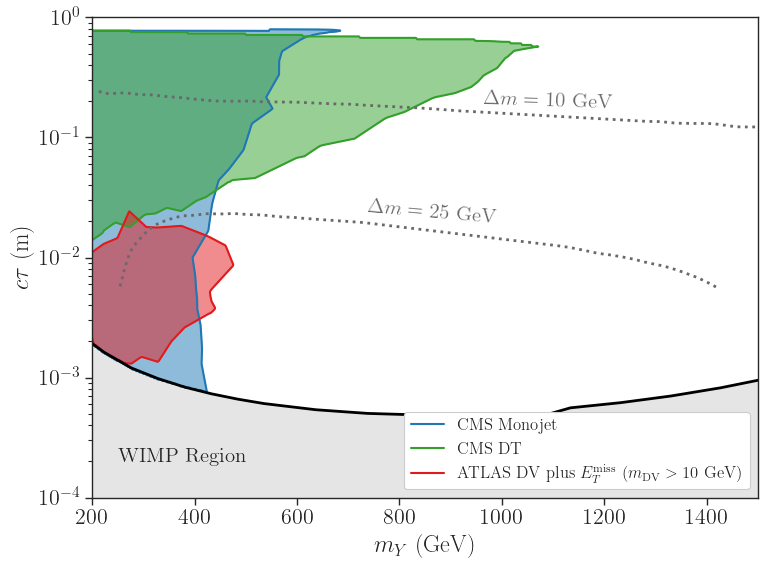

In [82]:
plt.figure(figsize=(8,6))
# plt.scatter(x,y,c='lightgray',s=30)
for label,newL in newLabels.items():
    ls = 'solid'
    if label not in allContours:
        continue
    contours = allContours[label]
    if 'average' in label:
        continue
    if label == 'CMS-EXO-20-004':
        continue
    if label == 'ATLAS-SUSY-2018-42':
        continue    
    if not contours:
        continue
    cVal = 1.0
    pts = contours[cVal] # Hack for avoiding out of order points
    if 'average' in label or 'nearest' in label:
        continue
    x = pts['mYGeV']
    y = (10**pts['log10tauns'])*0.3
    plt.plot(x,y,label=newL,linewidth=1.5,c=colors[label],linestyle=ls)
    plt.fill(x,y,label=None,c=colors[label],alpha=0.5)



dm10 = np.genfromtxt('./mY_DM10.csv',delimiter=',',names=True)
dm25 = np.genfromtxt('./mY_DM25.csv',delimiter=',',names=True)
plt.plot(dm10['mYGeV'],(10**dm10['log10tauns'])*0.3,linestyle='dotted',color='dimgray',linewidth=2.0)
plt.plot(dm25['mYGeV'],(10**dm25['log10tauns'])*0.3,linestyle='dotted',color='dimgray',linewidth=2.0)
pt = dm10[int(len(dm10)/1.33)]
pt[0] += 50.0
pt[1] = (10**pt[1])*0.3*1.05
plt.text(*pt,r'$\Delta m = 10$ GeV',fontsize=15,c='dimgray',rotation=-2)
pt = dm25[int(len(dm25)/1.8)+4]
pt[1] = (10**pt[1])*0.3
plt.text(*pt,r'$\Delta m = 25$ GeV',fontsize=15,c='dimgray',rotation=-5)


plt.text(250.,2e-4,'WIMP Region',fontsize=15)
plt.plot(maxCurve[:,2],maxCurve[:,1],c='black',linewidth=2)
plt.fill_between(maxCurve[:,2],maxCurve[:,1],label=None,alpha=0.1,color='black')
plt.xlim(200,1500)
plt.yscale('log')
plt.ylim(1e-4,1)
plt.legend(loc='lower right',fontsize=12,framealpha=1.0)
plt.xlabel(r'$m_{Y}$ (GeV)')
plt.ylabel(r'$c \tau$ (m)')
plt.tight_layout()
plt.savefig('excCurves_whitepaper_mDV10.png')
# plt.grid()
plt.show()

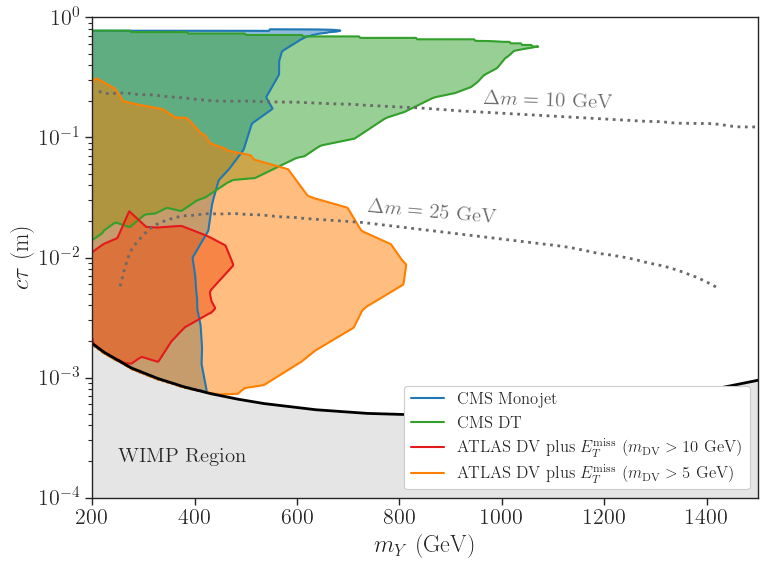

In [81]:
plt.figure(figsize=(8,6))
# plt.scatter(x,y,c='lightgray',s=30)
for label,newL in newLabels.items():
    if label not in allContours:
        continue
    contours = allContours[label]
    if 'average' in label:
        continue
    if label == 'CMS-EXO-20-004':
        continue
    if label == 'ATLAS-SUSY-2018-42':
        continue    
    if not contours:
        continue
    pts = contours[cVal] # Hack for avoiding out of order points
    x = pts['mYGeV']
    y = (10**pts['log10tauns'])*0.3
    plt.plot(x,y,label=newL,linewidth=1.5,c=colors[label],linestyle=ls)
    plt.fill(x,y,label=None,c=colors[label],alpha=0.5)



dm10 = np.genfromtxt('./mY_DM10.csv',delimiter=',',names=True)
dm25 = np.genfromtxt('./mY_DM25.csv',delimiter=',',names=True)
plt.plot(dm10['mYGeV'],(10**dm10['log10tauns'])*0.3,linestyle='dotted',color='dimgray',linewidth=2.0)
plt.plot(dm25['mYGeV'],(10**dm25['log10tauns'])*0.3,linestyle='dotted',color='dimgray',linewidth=2.0)
pt = dm10[int(len(dm10)/1.33)]
pt[0] += 50.0
pt[1] = (10**pt[1])*0.3*1.05
plt.text(*pt,r'$\Delta m = 10$ GeV',fontsize=15,c='dimgray',rotation=-2)
pt = dm25[int(len(dm25)/1.8)+4]
pt[1] = (10**pt[1])*0.3
plt.text(*pt,r'$\Delta m = 25$ GeV',fontsize=15,c='dimgray',rotation=-5)


plt.text(250.,2e-4,'WIMP Region',fontsize=15)
plt.plot(maxCurve[:,2],maxCurve[:,1],c='black',linewidth=2)
plt.fill_between(maxCurve[:,2],maxCurve[:,1],label=None,alpha=0.1,color='black')
plt.xlim(200,1500)
plt.yscale('log')
plt.ylim(1e-4,1)
plt.legend(loc='lower right',fontsize=12,framealpha=1.0)
plt.xlabel(r'$m_{Y}$ (GeV)')
plt.ylabel(r'$c \tau$ (m)')
plt.tight_layout()
plt.savefig('excCurves_whitepaper_mDV5.png')
# plt.grid()
plt.show()